📊 Génération du dataset d'entraînement...
✅ Dataset créé: 500 événements
   - Normal: 400
   - Anomalies: 100
✅ Scaler sauvegardé dans ../data/scaler.pkl

🎯 Entraînement Isolation Forest...
✅ Modèle entraîné!

📊 Évaluation du modèle:

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       400
    Anomalie       0.98      0.98      0.98       100

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

ROC-AUC Score: 0.9997

🔍 Calcul de l'importance des features...


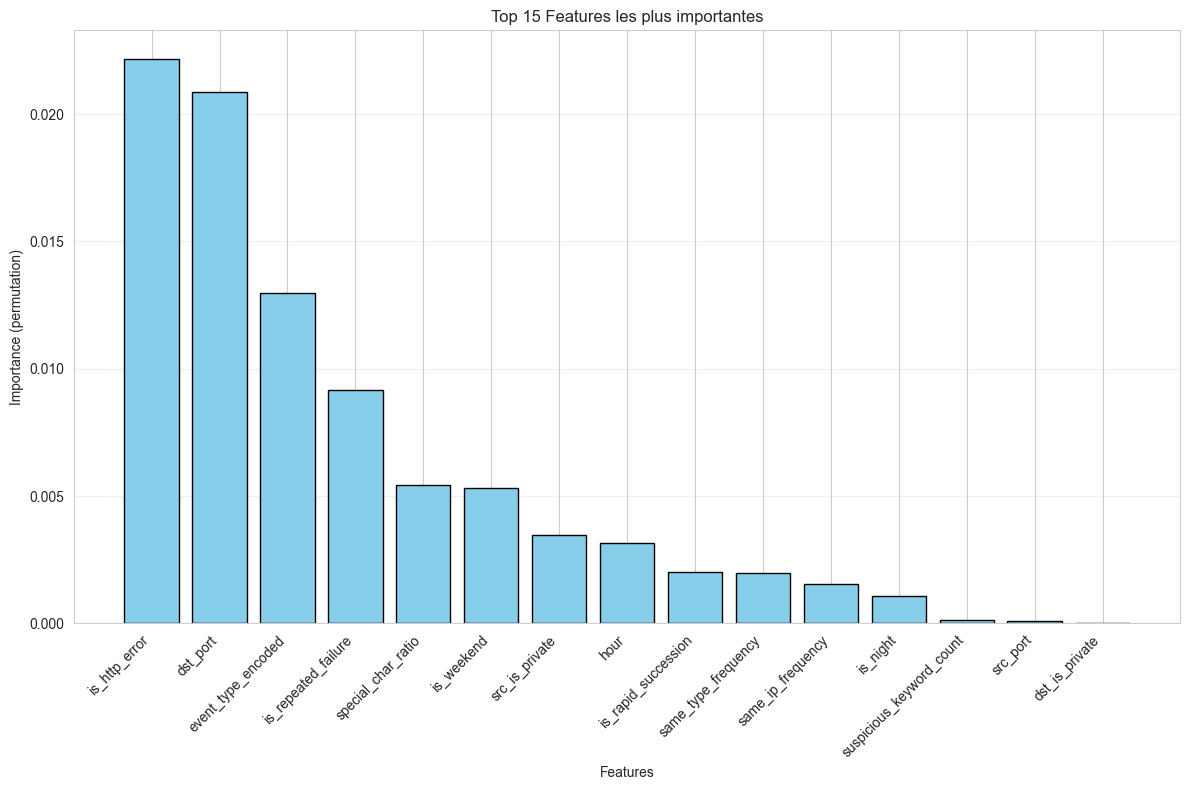


💾 Sauvegarde du modèle...
✅ Modèle sauvegardé: ../data/anomaly_model.pkl
✅ Dataset sauvegardé: ../data/logs_dataset.csv

✅ Script terminé avec succès.


In [1]:
"""
# SOC IA - Entraînement Détecteur d'Anomalies (CORRIGÉ FINAL)

Ce notebook entraîne un modèle Isolation Forest pour la détection d'anomalies
dans les logs de sécurité.

## Installation
!pip install scikit-learn pandas numpy matplotlib seaborn joblib
"""

# ## 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.inspection import permutation_importance
import joblib
from pathlib import Path

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# ## 2. Génération du Dataset d'Entraînement

def generate_training_dataset(n_normal=400, n_anomaly=100):
    """
    Génère un dataset synthétique pour l'entraînement
    """
    np.random.seed(42)
    
    # Événements normaux
    normal_data = {
        'hour': np.random.randint(8, 18, n_normal),  # Heures de bureau
        'day_of_week': np.random.randint(0, 5, n_normal),  # Jours de semaine
        'is_weekend': np.zeros(n_normal),
        'is_night': np.zeros(n_normal),
        'src_is_private': np.ones(n_normal),
        'dst_is_private': np.ones(n_normal),
        'src_port': np.random.randint(49152, 65535, n_normal),
        'dst_port': np.random.choice([80, 443, 22], n_normal),
        'is_common_port': np.ones(n_normal),
        'same_ip_frequency': np.random.randint(1, 5, n_normal),
        'same_type_frequency': np.random.randint(1, 10, n_normal),
        'time_since_last_similar': np.random.exponential(100, n_normal),
        'suspicious_keyword_count': np.random.randint(0, 2, n_normal),
        'message_length': np.random.randint(50, 200, n_normal),
        'special_char_ratio': np.random.uniform(0, 0.2, n_normal),
        'has_ip_pattern': np.random.choice([0, 1], n_normal, p=[0.7, 0.3]),
        'has_url_pattern': np.random.choice([0, 1], n_normal, p=[0.8, 0.2]),
        'http_code': np.random.choice([200, 201, 301, 404], n_normal),
        'is_http_error': np.random.choice([0, 1], n_normal, p=[0.9, 0.1]),
        'event_type_encoded': np.random.choice([2, 4, 6], n_normal),  # HTTP, DNS, login success
        'is_repeated_failure': np.zeros(n_normal),
        'is_rapid_succession': np.zeros(n_normal),
        'label': np.zeros(n_normal)
    }
    
    # Événements anormaux (attaques)
    anomaly_data = {
        'hour': np.random.choice([0, 1, 2, 3, 22, 23], n_anomaly),  # Heures suspectes
        'day_of_week': np.random.randint(0, 7, n_anomaly),
        'is_weekend': np.random.choice([0, 1], n_anomaly),
        'is_night': np.ones(n_anomaly),
        'src_is_private': np.zeros(n_anomaly),  # IPs externes
        'dst_is_private': np.ones(n_anomaly),
        'src_port': np.random.randint(1024, 49152, n_anomaly),
        'dst_port': np.random.choice([22, 3389, 445, 23], n_anomaly),
        'is_common_port': np.ones(n_anomaly),
        'same_ip_frequency': np.random.randint(10, 50, n_anomaly),  # Haute fréquence
        'same_type_frequency': np.random.randint(20, 100, n_anomaly),
        'time_since_last_similar': np.random.uniform(0.1, 5, n_anomaly),  # Rapide
        'suspicious_keyword_count': np.random.randint(2, 6, n_anomaly),
        'message_length': np.random.randint(100, 500, n_anomaly),
        'special_char_ratio': np.random.uniform(0.2, 0.6, n_anomaly),
        'has_ip_pattern': np.ones(n_anomaly),
        'has_url_pattern': np.random.choice([0, 1], n_anomaly, p=[0.3, 0.7]),
        'http_code': np.random.choice([401, 403, 404, 500], n_anomaly),
        'is_http_error': np.ones(n_anomaly),
        'event_type_encoded': np.random.choice([1, 3, 7], n_anomaly),  # SSH, port_scan, login_failure
        'is_repeated_failure': np.ones(n_anomaly),
        'is_rapid_succession': np.random.choice([0, 1], n_anomaly, p=[0.3, 0.7]),
        'label': np.ones(n_anomaly)
    }
    
    # Combinaison
    df_normal = pd.DataFrame(normal_data)
    df_anomaly = pd.DataFrame(anomaly_data)
    df = pd.concat([df_normal, df_anomaly], ignore_index=True)
    
    # Mélange
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

# Génération du dataset
print("📊 Génération du dataset d'entraînement...")
df = generate_training_dataset(n_normal=400, n_anomaly=100)

print(f"✅ Dataset créé: {len(df)} événements")
print(f"   - Normal: {(df['label'] == 0).sum()}")
print(f"   - Anomalies: {(df['label'] == 1).sum()}")

# ## 4. Préparation des Données

# Séparation features / labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Création des dossiers si nécessaire
Path('../data').mkdir(exist_ok=True, parents=True)

# Normalisation (Optionnel mais sauvegardé pour usage futur)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, '../data/scaler.pkl')
print("✅ Scaler sauvegardé dans ../data/scaler.pkl")

# ## 5. Entraînement du Modèle

print("\n🎯 Entraînement Isolation Forest...")

# Création du modèle
# IMPORTANT: n_jobs=1 pour éviter les plantages de mémoire sur certains environnements
model = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.2,  # 20% d'anomalies attendues
    max_features=1.0,
    bootstrap=False,
    n_jobs=1,           # <--- CORRECT
    random_state=42,
    verbose=0
)

# Entraînement (unsupervised)
model.fit(X)

print("✅ Modèle entraîné!")

# Prédictions et Scores pour l'évaluation
y_pred = model.predict(X)  # -1 = anomalie, 1 = normal
y_pred_binary = np.where(y_pred == -1, 1, 0)
anomaly_scores = model.decision_function(X)
anomaly_scores_normalized = 1 / (1 + np.exp(anomaly_scores * 4))

# ## 6. Évaluation du Modèle

print("\n📊 Évaluation du modèle:\n")
print(classification_report(y, y_pred_binary, target_names=['Normal', 'Anomalie']))

auc = roc_auc_score(y, anomaly_scores_normalized)
print(f"ROC-AUC Score: {auc:.4f}")

# ## 7. Feature Importance (CORRIGÉ)

print("\n🔍 Calcul de l'importance des features...")

# --- Fonction de scoring personnalisée pour Isolation Forest ---
def custom_if_scorer(estimator, X, y):
    # Prédictions du modèle (-1 = anomalie, 1 = normal)
    preds = estimator.predict(X)
    # Conversion en binaire (1 = anomalie, 0 = normal) pour matcher 'y'
    preds_binary = np.where(preds == -1, 1, 0)
    # On utilise le F1-score comme métrique
    return f1_score(y, preds_binary)

# Appel de permutation_importance
# IMPORTANT: n_jobs=1 ici aussi pour éviter l'erreur "Worker stopped"
perm_importance = permutation_importance(
    model, X, y, 
    scoring=custom_if_scorer,  
    n_repeats=10, 
    random_state=42, 
    n_jobs=1  # <--- CORRECTION CRUCIALE ICI
)

feature_names = [
    'hour', 'day_of_week', 'is_weekend', 'is_night',
    'src_is_private', 'dst_is_private', 'src_port', 'dst_port', 'is_common_port',
    'same_ip_frequency', 'same_type_frequency', 'time_since_last_similar',
    'suspicious_keyword_count', 'message_length', 'special_char_ratio',
    'has_ip_pattern', 'has_url_pattern', 'http_code', 'is_http_error',
    'event_type_encoded', 'is_repeated_failure', 'is_rapid_succession'
]

# Tri par importance
indices = np.argsort(perm_importance.importances_mean)[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(indices[:15])), 
        perm_importance.importances_mean[indices[:15]],
        color='skyblue', edgecolor='black')
plt.xticks(range(len(indices[:15])), 
           [feature_names[i] for i in indices[:15]], 
           rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance (permutation)')
plt.title('Top 15 Features les plus importantes')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ## 8. Sauvegarde du Modèle

print("\n💾 Sauvegarde du modèle...")

model_path = '../data/anomaly_model.pkl'
joblib.dump(model, model_path)
print(f"✅ Modèle sauvegardé: {model_path}")

# Sauvegarde du dataset
dataset_path = '../data/logs_dataset.csv'
df.to_csv(dataset_path, index=False)
print(f"✅ Dataset sauvegardé: {dataset_path}")

print("\n✅ Script terminé avec succès.")